In [2]:
from inrad_reader import inrad_to_cf
import matplotlib.pyplot as plt

import pyart
import cartopy
import os
import numpy as np
import tempfile
import xarray as xr
import sklearn.cluster


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def set_font_func(ftsz):
    # set the fontsize for the plots
    plt.rcParams['xtick.labelsize']=ftsz
    plt.rcParams['ytick.labelsize']=ftsz
    plt.rcParams['axes.labelsize'] = ftsz
    plt.rcParams['legend.fontsize'] = ftsz
    plt.rcParams['axes.titlesize'] = ftsz

# Write into pyart object

In [5]:
# read nc data and write into pyart object
radar_name = 'DEMS'
date_str = '20180828'
time_str = ['005229','022230','035230','060230','080229','090024','113230','142023','144229'] # picked for DEMS20180828

# radar_name = 'VANP'
# date_str = '20180706'
# time_str = ['001202','071203','092202','105203','122202','174202','190203','202202','232202'] # picked for VANP20180706

test_file_path = f'/project/projectdirs/m1657/zfeng/indian_radar/{radar_name}-RADAR/{date_str}/'
cfradial_path = '/global/cscratch1/sd/chen696/inrad/'

for itime in range(9):
    print(test_file_path +f'T_HAHA00_C_{radar_name}_{date_str}{time_str[itime]}_*.nc')
    radar = inrad_to_cf.read_multi_radar(test_file_path + 
                                         f'T_HAHA00_C_{radar_name}_{date_str}{time_str[itime]}_*.nc')
    display = pyart.graph.RadarDisplay(radar)
    pyart.io.write_cfradial(f'{cfradial_path}test_cfradial_{radar_name}_{date_str}{time_str[itime]}.nc', radar)

/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828005229_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828022230_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828035230_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828060230_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828080229_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828090024_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828113230_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828142023_*.nc
/project/projectdirs/m1657/zfeng/indian_radar/DEMS-RADAR/20180828/T_HAHA00_C_DEMS_20180828144229_*.nc


# Gridding

In [6]:
#%%time

iradar=1

if iradar==1:

    radar_name = 'DEMS'
    date_str = '20180828'
    time_str = ['005229','022230','035230','060230','080229','090024','113230','142023','144229'] # picked for DEMS20180828

elif iradar==2:
    
    radar_name = 'VANP'
    date_str = '20180706'
    time_str = ['001202','071203','092202','105203','122202','174202','190203','202202','232202'] # picked for VANP20180706

save_path = '/global/cscratch1/sd/chen696/inrad/'
os.system(f'mkdir -p {save_path}')

for itime in range(1):
    
    print(time_str[itime])
    
    # read radar object
    radar = pyart.io.read_cfradial(f'{cfradial_path}test_cfradial_{radar_name}_{date_str}{time_str[itime]}.nc')
    nsweep = np.max(radar.sweep_number['data'])+1 # number of sweep
    
    # each unique sweep elevation
    elevation_data = radar.elevation['data']
    unique, counts = np.unique(elevation_data, return_counts=True)
    
    # extract the elevation for each sweep
    elevation_data = radar.elevation['data']
    kmeans_model = sklearn.cluster.KMeans(n_clusters=nsweep, random_state=0).fit(elevation_data.reshape(-1, 1))
    ele_clusters = kmeans_model.fit_predict(elevation_data.reshape(-1, 1))
    elevation_sweep = np.zeros(nsweep) # elevation for each sweep
    for ii in range(nsweep):
        unique, counts = np.unique(elevation_data[ele_clusters==ii], return_counts=True)
        elevation_sweep[ii] = unique[np.argmax(counts)]
    elevation_sweep = np.sort(elevation_sweep)
                
    # gridding 
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_invalid('reflectivity')
    grid_data = pyart.map.grid_from_radars(radar, grid_shape = (40,301,301), 
                                       grid_limits = ((500,20000),(-150000,150000), (-150000,150000)), 
                                       fields = ('reflectivity','spectrum_width'),
                                       weighting_function = 'Barnes2',roi_func = 'dist',# 'dist_beam'
                                       z_factor=0.05, xy_factor=0.02, min_radius=500.0,
                                       #h_factor=1.0, nb=1.5, bsp=2.0, min_radius=500.0,
                                       gridding_algo = 'map_gates_to_grid',gatefilter=gatefilter)
    
    # writing
    temp_file = tempfile.NamedTemporaryFile()
    pyart.io.write_grid(temp_file.name, grid_data)
    gridradObj = xr.open_dataset(temp_file.name, decode_times=False)   
    
    gridradObj.attrs['nsweep'] = nsweep
    gridradObj.expand_dims({'nsweep':int(nsweep)})
    gridradObj['elevation_sweep'] = (('nsweep'), elevation_sweep)
    gridradObj.expand_dims({'unique_elevation':unique.shape[0]})
    gridradObj['elevations'] = (('unique_elevation',unique))
    gridradObj['counts_elevations'] = (('unique_elevation',counts))
    
    comp = dict(zlib=True) # Set encoding/compression for all variables
    encoding = {var: comp for var in gridradObj.data_vars}
    grid_file_name = f'{save_path}/test_grid_{radar_name}_{date_str}{time_str[itime]}.nc'
    gridradObj.to_netcdf(path=grid_file_name, mode='w', format='NETCDF4_CLASSIC', unlimited_dims='time', \
                    encoding=encoding, )
    

005229


# Plots

plots


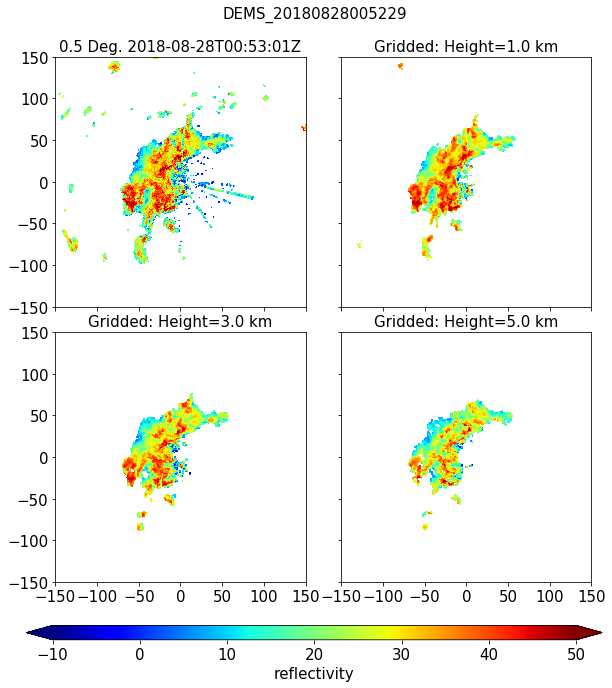

In [8]:
# plottings
varname = 'reflectivity'
ftsz=15
set_font_func(ftsz)
vmin=-10
vmax=50
height = np.linspace(500,20000,40)
print('plots')

(fig,axes) = plt.subplots(2,2,sharex='col', sharey='row',figsize=(10,10))
fig.subplots_adjust(bottom=0.18,top=0.91,wspace=0.05,hspace=0.1)

ax = axes[0,0]
display = pyart.graph.RadarDisplay(radar) # pyart radar project
ax.set(aspect='equal',xlim=[-150,150],ylim=[-150,150])
display.plot(varname,0, vmin=vmin, vmax=vmax, ax=ax,axislabels=('',''),\
             axislabels_flag=True,colorbar_flag=False,cmap='jet',\
             title = display.generate_title(varname,0)[1:-14])

for ii in range(1,4):

    ax = axes[int(ii/2),ii-2*int(ii/2)]
    iht = 1 + (ii-1)*4
    plt1 = ax.pcolormesh(grid_data.x['data']/1000.0,grid_data.y['data']/1000.0,
                         grid_data.fields[varname]['data'][iht,:,:],vmin=vmin,  vmax=vmax, cmap='jet')
    ax.set_title(f'Gridded: Height={height[iht]*1.0e-3} km')
    ax.set_xticks([-150,-100,-50,0,50,100,150])
    ax.set_yticks([-150,-100,-50,0,50,100,150])
    ax.set(aspect='equal',xlim=[-150,150],ylim=[-150,150])

    fig.suptitle(f'{radar_name}_{date_str}{time_str[itime]}',fontsize=ftsz)

ax1 = fig.add_axes([0.1,0.1,0.8,0.02]) 
mybar = fig.colorbar(plt1, cax=ax1, ticks = [-10,0,10,20,30,40,50], orientation='horizontal',fraction =0.1,extend='both')
mybar.set_label(varname, fontsize=ftsz)

fig.savefig(f'{save_path}/{radar_name}_{date_str}{time_str[itime]}',dpi=fig.dpi,bbox_inches='tight', pad_inches=0.5)
#     plt.close()